In [1]:
import os
import polars as pl
import polars
import numpy as np
import matplotlib.pyplot as plt
import pyvisgraph as vg
import japanize_matplotlib

import pickle

import geopandas as gpd
from shapely import unary_union, wkt

from tqdm import tqdm

In [2]:
def create_grid_visualization(df):
    # グリッドの次元を取得
    x_max = df['grid_x'].max() + 1
    y_max = df['grid_y'].max() + 1
    
    # 2D配列に変換
    grid = np.zeros((y_max, x_max))
    for row in df.iter_rows():
        x, y, cost = row
        grid[y, x] = cost
    
    # プロットの作成
    plt.figure(figsize=(12, 8))
    
    # pcolormeshでヒートマップを描画
    im = plt.pcolormesh(grid, cmap='viridis', shading='auto')
    
    # カラーバーを追加
    
    plt.colorbar(im, label='Cost(分)')
    
    # 軸ラベルを設定
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.title("Tobler's hiking function")
    
    # グリッドを表示
    plt.grid(True)
    
    return plt

In [3]:
def get_site_grid_coords(df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換
    
    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム
        
    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
            df_obsidian
            .select([
                (pl.col("遺跡ID")), 
                (pl.col('緯度')),
                (pl.col('経度'))
            ])
            .unique(subset=["遺跡ID"])
            .sort("遺跡ID")
            .with_columns([
                ((pl.col('経度') - (x_first_center - (x_spacing / 2))) / x_spacing).cast(pl.Int64).alias("grid_x"),
                ((pl.col('緯度') - (y_first_center - (y_spacing / 2))) / y_spacing).cast(pl.Int64).alias("grid_y")
            ])
        )

    site_grid_coords = np.column_stack([
            coords['grid_x'].to_numpy(),
            coords['grid_y'].to_numpy()
        ])

    return site_grid_coords

In [4]:
SCHEMA = pl.Schema({
    'grid_x': pl.Int64,
    'x': pl.Float64,
    'grid_y': pl.Int64,
    'y': pl.Float64,
    'mesh_code_5th': pl.Int64,
    'average_elevation': pl.Float64,
    'maximum_elevation': pl.Float64,
    'minimum_elevation': pl.Float64,
    'minimum_elevation_code': pl.Int64,
    'maximum_slope_angle': pl.Float64,
    'maximum_slope_direction': pl.Int64,
    'minimum_slope_angle': pl.Float64,
    'minimum_slope_direction': pl.Int64,
    'average_slope_angle': pl.Float64,
    'geometry': pl.Utf8,
    'is_sea': pl.Boolean,
    'walking_velocity': pl.Float64,
    'travel_time': pl.Float64,
    'elevation_diff_east': pl.Float64,
    'angle_east': pl.Float64,
    'walking_velocity_east': pl.Float64,
    'travel_time_east': pl.Float64,
    'elevation_diff_west': pl.Float64,
    'angle_west': pl.Float64,
    'walking_velocity_west': pl.Float64,
    'travel_time_west': pl.Float64,
    'elevation_diff_north': pl.Float64,
    'angle_north': pl.Float64,
    'walking_velocity_north': pl.Float64,
    'travel_time_north': pl.Float64,
    'elevation_diff_south': pl.Float64,
    'angle_south': pl.Float64,
    'walking_velocity_south': pl.Float64,
    'travel_time_south': pl.Float64,
    'cost_kouzu': pl.Float64,
    'cost_shinshu': pl.Float64,
    'cost_hakone': pl.Float64,
    'cost_takahara': pl.Float64,
    'cost_river': pl.Float64,
    'x_meter': pl.Float64,
    'y_meter': pl.Float64
})

data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"]  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
        # 全く欠損していない行をis_validとする
        .with_columns([
            pl.all_horizontal(
                [
                    ~pl.col(col).is_null()
                    for col in df_elevation.columns
                ]
            )
            .alias('is_valid')
        ])
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


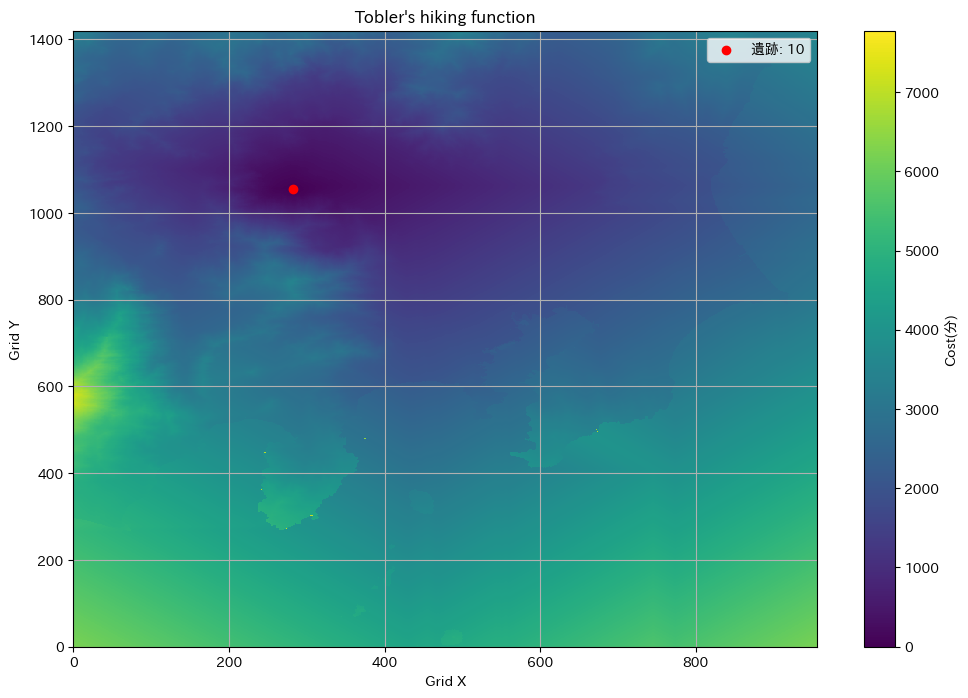

In [5]:

i = 10

x = site_grid_coords[i, 0]
y = site_grid_coords[i, 1]

### pickleで保存したファイルを読み込み
with open(os.path.join(data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"), mode='br') as fi:
  min_costs = pickle.load(fi)

width = 956
height = 1420

# grid_x, grid_y, min_cost_minutsという列を持つpl.DataFrameを作成
min_costs_df = pl.DataFrame({
    "grid_x": np.tile(np.arange(width), height),
    "grid_y": np.repeat(np.arange(height), width),
    f"cost_{i}": min_costs
})

# 使用例:
plt_ = create_grid_visualization(min_costs_df)
plt_.scatter(x, y, color='red', label=f"遺跡: {i}")
plt_.legend()
plt_.show()

### 説明変数を入れてカーネル回帰とIPPを同時推定

In [6]:
import os
from typing import Tuple
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import japanize_matplotlib

In [7]:
# 地点ごとの産地構成比を計算

def preprocess_data(
    df: pl.DataFrame,
    target_period: int,
    target_origin: str
) -> Tuple[np.ndarray, np.ndarray]:
    """
    解析用のデータを前処理
    
    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
    target_period : int
        対象時期
    target_origin : str
        対象産地カテゴリ
        
    Returns
    -------
    counts : np.ndarray
        各遺跡での出土数（インデックスが遺跡ID）
    target_counts : np.ndarray
        対象産地の出土数（インデックスが遺跡ID）
    """
    # 全遺跡IDのリストを取得
    max_site_id = df['遺跡ID'].max()
    
    # 対象時期のデータのみ抽出
    period_df = df.filter(pl.col('時期') == target_period)
    
    # 全体のカウント
    counts = (
        period_df
        .group_by('遺跡ID')
        .agg([pl.len().alias('count')])
        .join(
            pl.DataFrame({
                '遺跡ID': np.arange(max_site_id + 1)
            }),
            on='遺跡ID',
            how='right'
        )
        .fill_null(0)
        .sort('遺跡ID')['count']
        .to_numpy()
    )
    
    # 対象産地のカウント
    target_counts = (
        period_df
        .filter(pl.col('産地カテゴリ') == target_origin)
        .group_by('遺跡ID')
        .agg([pl.len().alias('count')])
        .join(
            pl.DataFrame({
                '遺跡ID': np.arange(max_site_id + 1)
            }),
            on='遺跡ID',
            how='right'
        )
        .fill_null(0)
        .sort('遺跡ID')['count']
        .to_numpy()
    )
    
    return counts, target_counts


In [8]:
def create_site_coords(df: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をラジアンに変換
    
    Parameters
    ----------
    df : pl.DataFrame
        入力データフレーム
        
    Returns
    -------
    np.ndarray
        遺跡の座標（ラジアン）
    """
    # 座標をラジアンに変換
    coords = (
        df
        .select([
            (pl.col("遺跡ID")), 
            (pl.col('緯度') * np.pi / 180).alias('lat_rad'),
            (pl.col('経度') * np.pi / 180).alias('lon_rad')
        ])
        .unique(subset=["遺跡ID"])
        .sort("遺跡ID")
    )
    
    # 座標と出土数を numpy 配列に変換
    site_coords = np.column_stack([
        coords['lat_rad'].to_numpy(),
        coords['lon_rad'].to_numpy()
    ])

    return site_coords

In [9]:
def get_site_grid_coords(df_obsidian: pl.DataFrame, df_elevation: pl.DataFrame) -> np.ndarray:
    """
    遺跡の座標をグリッド座標に変換
    
    Parameters
    ----------
    df_obsidian : pl.DataFrame
        遺跡のデータフレーム
    df_elevation : pl.DataFrame
        標高のデータフレーム
        
    Returns
    -------
    np.ndarray
        遺跡のグリッド座標
    """

    x_spacing = df_elevation["x"].unique().sort().diff().mode()[0]
    y_spacing = df_elevation["y"].unique().sort().diff().mode()[0]
    x_first_center = df_elevation["x"].min()
    y_first_center = df_elevation["y"].min()

    coords = (
            df_obsidian
            .select([
                (pl.col("遺跡ID")), 
                (pl.col('緯度')),
                (pl.col('経度'))
            ])
            .unique(subset=["遺跡ID"])
            .sort("遺跡ID")
            .with_columns([
                ((pl.col('経度') - (x_first_center - (x_spacing / 2))) / x_spacing).cast(pl.Int64).alias("grid_x"),
                ((pl.col('緯度') - (y_first_center - (y_spacing / 2))) / y_spacing).cast(pl.Int64).alias("grid_y")
            ])
        )

    site_grid_coords = np.column_stack([
            coords['grid_x'].to_numpy(),
            coords['grid_y'].to_numpy()
        ])

    return site_grid_coords

In [10]:
# 重みの初期計算
def K(x, sigma):
    return np.exp(-0.5 * (x**2) / (sigma**2)) / (2 * np.pi * sigma**2)

def calculate_weights_matrix(
    grid_coords: np.ndarray, #(グリッド数, 2)
    site_coords: np.ndarray, #(遺跡数, 2)
    sigma: float,
) -> np.ndarray: # (グリッド数, 遺跡数)
    """
    重み行列を計算
    """
    R = 6371  # 地球の半径(km)
    
    # 通常の距離計算
    dlat = grid_coords[:, np.newaxis, 0] - site_coords[np.newaxis, :, 0]
    dlon = grid_coords[:, np.newaxis, 1] - site_coords[np.newaxis, :, 1]
    
    a = (np.sin(dlat/2)**2 + 
         np.cos(grid_coords[:, np.newaxis, 0]) * 
         np.cos(site_coords[np.newaxis, :, 0]) * 
         np.sin(dlon/2)**2)
    
    distances = 2 * R * np.arcsin(np.sqrt(a))
    
    weights = K(distances, sigma)

    return weights

In [11]:
def calculate_distance_W(
    W_grid: np.ndarray,
    W_sites: np.ndarray,
) -> np.ndarray:
    """
    説明変数間の距離行列を計算

    Parameters
    ----------
    W_grid : np.ndarray
        グリッドの説明変数 (グリッド数, p)
    W_sites : np.ndarray
        遺跡の説明変数 (遺跡数, p)

    p は説明変数の次元数

    Returns
    -------
    np.ndarray
        説明変数間の距離行列 (グリッド数, 遺跡数, p)
    """
    # W_gridを(グリッド数, 1, p)に、W_sitesを(1, 遺跡数, p)に reshape
    # ブロードキャストにより自動的に(グリッド数, 遺跡数, p)に拡張される
    W_grid_expanded = W_grid[:, np.newaxis, :]
    W_sites_expanded = W_sites[np.newaxis, :, :]
    
    # ユークリッド距離の計算
    distances = np.abs(W_grid_expanded - W_sites_expanded)
    
    return distances

In [12]:
def create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh):
    # 地形マスクの作成
    land_points = df_elevation.select([
        'x',
        'y',
        pl.col('is_sea').cast(pl.Boolean)
    ]).to_numpy()
    
    lons_1d = lon_mesh[0, :]
    lats_1d = lat_mesh[:, 0]
    land_mask = np.full(lon_mesh.shape, False)
    
    x_indices = np.searchsorted(lons_1d, land_points[:, 0])
    y_indices = np.searchsorted(lats_1d, land_points[:, 1])
    valid_points = (
        (x_indices > 0) & 
        (x_indices < len(lons_1d)) & 
        (y_indices > 0) & 
        (y_indices < len(lats_1d))
    )
    is_sea = land_points[valid_points, 2].astype(bool)
    land_mask[y_indices[valid_points], x_indices[valid_points]] = ~is_sea
    
    # grid_coordsの各点について、対応するland_maskの値を取得
    grid_lons = grid_coords[:, 1] * 180/np.pi  # ラジアンから度に変換
    grid_lats = grid_coords[:, 0] * 180/np.pi
    
    grid_x_indices = np.searchsorted(lons_1d, grid_lons)
    grid_y_indices = np.searchsorted(lats_1d, grid_lats)
    
    # インデックスが有効範囲内にあることを確認
    valid_grid_points = (
        (grid_x_indices > 0) & 
        (grid_x_indices < len(lons_1d)) & 
        (grid_y_indices > 0) & 
        (grid_y_indices < len(lats_1d))
    )
    
    # 海上の点の重みを0に設定
    grid_is_land = np.zeros(len(grid_coords), dtype=bool)
    grid_is_land[valid_grid_points] = land_mask[
        grid_y_indices[valid_grid_points],
        grid_x_indices[valid_grid_points]
    ]

    return grid_is_land

In [13]:
def calculate_ratios(
    weights: np.ndarray,
    counts: np.ndarray,
    target_counts: np.ndarray
) -> np.ndarray:
    """
    重み付き比率を計算
    
    Parameters
    ----------
    weights : np.ndarray
        重み行列
    counts : np.ndarray
        各遺跡での出土数
    target_counts : np.ndarray
        対象産地の出土数
        
    Returns
    -------
    ratios : np.ndarray
        各グリッド点での重み付き比率
    """
    # 重み付き合計を計算
    weighted_total = np.sum(weights * counts, axis=1)
    weighted_target = np.sum(weights * target_counts, axis=1)
    
    # 比率計算（0除算を防ぐ）
    ratios = np.where(
        weighted_total > 0,
        weighted_target / weighted_total,
        0
    )
    
    return ratios

In [14]:
def plot_contour(df, x_col='x', y_col='y', value_col='cost_kouzu', figsize=(12, 8), plot_probability=False, n_levels=30, cmap='Blues'):

    import japanize_matplotlib

    # まず海陸判定のマスクを作成
    mask = (
        df
        .with_columns(
            (~pl.col('is_sea')).alias("is_not_sea")
        )
        .pivot(
            values='is_not_sea',
            on=x_col,
            index=y_col
        )
    )

    # 値のピボットテーブルを作成
    grid_data = (
        df
        .pivot(
            values=value_col,
            on=x_col,
            index=y_col
        )
    )

    # マスクを適用（y_col列は保持）
    grid_data = grid_data.with_columns(
        [
            pl.col(col) * mask.get_column(col)
            for col in grid_data.columns
            if col != y_col
        ]
    )
    
    # メッシュグリッドの作成
    x_mesh = np.array(grid_data.columns[1:], dtype=float)
    y_mesh = np.array(grid_data.to_numpy()[:, 0], dtype=float)
    values_mesh = grid_data.to_numpy()[:, 1:]
    
    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_probability:
        # 確率表示モード（0-1の範囲）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh,
            levels=np.linspace(0, 1, n_levels + 1),
            cmap=cmap,
            alpha=0.7,
            vmin=0,
            vmax=1
        )
    else:
        # 通常モード（データをそのまま使用）
        contour = ax.contourf(
            x_mesh, y_mesh, values_mesh, 
            levels=n_levels, 
            cmap=cmap,
            alpha=0.7
        )
    
    # カラーバーの追加
    if plot_probability:
        # カラーバー（0-1の範囲に固定）
        plt.colorbar(contour, ax=ax, label='Ratio', ticks=np.linspace(0, 1, 6))
    else:
        plt.colorbar(contour, ax=ax)
    
    # ラベルの設定
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')
    
    return fig, ax

In [15]:
SCHEMA = pl.Schema({
    'grid_x': pl.Int64,
    'x': pl.Float64,
    'grid_y': pl.Int64,
    'y': pl.Float64,
    'mesh_code_5th': pl.Int64,
    'average_elevation': pl.Float64,
    'maximum_elevation': pl.Float64,
    'minimum_elevation': pl.Float64,
    'minimum_elevation_code': pl.Int64,
    'maximum_slope_angle': pl.Float64,
    'maximum_slope_direction': pl.Int64,
    'minimum_slope_angle': pl.Float64,
    'minimum_slope_direction': pl.Int64,
    'average_slope_angle': pl.Float64,
    'geometry': pl.Utf8,
    'is_sea': pl.Boolean,
    'walking_velocity': pl.Float64,
    'travel_time': pl.Float64,
    'elevation_diff_east': pl.Float64,
    'angle_east': pl.Float64,
    'walking_velocity_east': pl.Float64,
    'travel_time_east': pl.Float64,
    'elevation_diff_west': pl.Float64,
    'angle_west': pl.Float64,
    'walking_velocity_west': pl.Float64,
    'travel_time_west': pl.Float64,
    'elevation_diff_north': pl.Float64,
    'angle_north': pl.Float64,
    'walking_velocity_north': pl.Float64,
    'travel_time_north': pl.Float64,
    'elevation_diff_south': pl.Float64,
    'angle_south': pl.Float64,
    'walking_velocity_south': pl.Float64,
    'travel_time_south': pl.Float64,
    'cost_kouzu': pl.Float64,
    'cost_shinshu': pl.Float64,
    'cost_hakone': pl.Float64,
    'cost_takahara': pl.Float64,
    'cost_river': pl.Float64,
    'x_meter': pl.Float64,
    'y_meter': pl.Float64
})

In [16]:
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

df_elevation = pl.read_csv(
    os.path.join(data_dir, "11_gdf_elevation.csv"),
    null_values=["nan"]  # "nan"をnullとして扱う
)
df_elevation = (
    # データ型を変換
    df_elevation.cast(SCHEMA)
        # 全く欠損していない行をis_validとする
        .with_columns([
            pl.all_horizontal(
                [
                    ~pl.col(col).is_null()
                    for col in df_elevation.columns
                ]
            )
            .alias('is_valid')
        ])
)

df_obsidian = pl.read_csv(os.path.join(data_dir, "11_gdf_obsidian.csv"))
df_sites = pl.read_csv(os.path.join(data_dir, "11_gdf_sites.csv"))

time_period_name = {
    0: "早期・早々期",
    1: "前期",
    2: "中期",
    3: "後期",
    4: "晩期"
}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

sigma = 500
sigma_for_sites = 0.1

# =======================================================================================

# メッシュグリッドを作成
lon_mesh, lat_mesh = np.meshgrid(
    df_elevation['x'].unique().sort(),  # 経度の一意な値
    df_elevation['y'].unique().sort()   # 緯度の一意な値
)

print(lon_mesh.shape, lat_mesh.shape)

# 遺跡の位置: (遺跡数, 2)
site_coords = create_site_coords(df_obsidian)

# グリッドの位置座標: (グリッド数, 2)
grid_coords = np.column_stack([
    lat_mesh.ravel() * np.pi / 180,
    lon_mesh.ravel() * np.pi / 180
])

(1420, 956) (1420, 956)


In [17]:
df_sites = (
    df_sites
        .join(
            df_elevation.drop(["x", "y"]).with_columns([pl.col("mesh_code_5th").cast(pl.Int64).alias("mesh_code_5th")]),
            left_on="メッシュコード", 
            right_on="mesh_code_5th", 
            how="left"
        )
)

## 説明変数を入れたcoordsを作成する

In [18]:
# 説明変数の一覧
variable_names = [
    'average_elevation', 
    'average_slope_angle', 
    'cost_kouzu',
    'cost_shinshu',
    'cost_hakone',
    'cost_takahara',
    'cost_river'
]

# grid_coordsに対応する形で説明変数を取得: (グリッド数, p)
W_grids = df_elevation.sort(['y', 'x']).select(variable_names).to_numpy().astype(np.float64)

# site_coordsに対応する形で説明変数を取得: (遺跡数, p)
W_sites = df_sites.sort('遺跡ID').select(variable_names).to_numpy().astype(np.float64)

In [19]:
# ====================
# 距離行列を読み込む
# ====================

# 距離行列の読み込み
### pickleで保存したファイルを読み込み

#distances = np.zeros((len(grid_coords), len(site_coords)))
#for i in range(len(site_coords)):
#    with open(os.path.join(data_dir, "16_tobler_distance_with_coast_50_average", f"distance_siteID_{i}"), mode='br') as fi:
#        min_costs = pickle.load(fi)
#        distances[:, i] = min_costs

In [20]:
# ====================
# 重み行列を計算
# ====================

#weights = K(distances, sigma)

In [32]:
#print("creating weights matrix...")
# 陸地のみの重み行列の計算
#weights = calculate_weights_matrix(
#    grid_coords, site_coords, sigma
#)

# 説明変数間の距離行列の計算
#print("calculating distance_W...")
#distance_W = calculate_distance_W(W_grids, W_sites)

#weights_W = K(distance_W, sigma).prod(axis=2)

#weights *= weights_W

#print("updating weights matrix...")

# 重みの更新
#grid_is_land = create_land_mask(grid_coords, df_elevation, lon_mesh, lat_mesh)

# 海上の点からの重みをすべて0に
#weights *= grid_is_land[:, np.newaxis]

# 遺跡についての計算 ============================================================================
        
# 遺跡の一意な地点を取得
unique_sites = df_obsidian.unique(subset=['遺跡ID']).sort('遺跡ID')

# 計算対象の遺跡の座標をラジアンに変換
#target_coords_sites = np.column_stack([
#    unique_sites['緯度'].to_numpy() * np.pi / 180,
#    unique_sites['経度'].to_numpy() * np.pi / 180
#])

In [22]:
# ============================
# sites同士の距離行列を計算
# ============================

#site_grid_coords = get_site_grid_coords(df_obsidian, df_elevation)

#def idx(x, y):
#    return y * width + x

# distancesは(グリッド数, 遺跡数)の形状なので、i=idx(site_grid_coords)として、distances[i]をスライスすれば、(遺跡数, 遺跡数)の形状になる
#site_grid_idx = np.vectorize(idx)(site_grid_coords[:, 0], site_grid_coords[:, 1])

#distances_sites = distances[site_grid_idx]
#weights_sites = K(distances_sites, sigma_for_sites)

In [23]:
#weights.shape, weights_sites.shape

In [24]:
# target_period = 0で実験
target_period = 0
counts_all = np.zeros((len(site_coords), len(origin_order)-1))
for i, origin in enumerate(origin_order[:-1]):
    counts, target_counts = preprocess_data(
        df_obsidian, target_period, origin
    )
    counts_all[:, i] = target_counts

In [25]:
site_coords.shape, counts_all.shape, W_sites.shape, grid_coords.shape, W_grids.shape

((274, 2), (274, 4), (274, 7), (1357520, 2), (1357520, 7))

In [26]:
grid_coords

array([[0.59415735, 2.40858164],
       [0.59415735, 2.40863618],
       [0.59415735, 2.40869072],
       ...,
       [0.64575364, 2.46055973],
       [0.64575364, 2.46061427],
       [0.64575364, 2.46066881]])

In [27]:
# ------------------------------------------------------------------------------------
# Cell 7 : 可視化
# ------------------------------------------------------------------------------------


def plot_result(pi_grid, target_origin_idx, df_elevation=df_elevation, df_sites=df_sites, target_period=0):
    # counts_allをaxis=1方向で正規化して、ratio_trueを作成
    ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)
    # ratio_trueのNaNを0に置き換え
    ratio_true = np.nan_to_num(ratio_true)

    ratio_sites_df = pl.DataFrame({
        '遺跡ID': df_sites['遺跡ID']
    })

    for i, target_origin in enumerate(origin_order[:-1]):
        ratio_sites_df = ratio_sites_df.join(
            pl.DataFrame({
                '遺跡ID': unique_sites['遺跡ID'],
                f"比率_{target_period}_{target_origin}": ratio_true[:, i]
            }),
            on="遺跡ID"
        )
        if f"比率_{target_period}_{target_origin}" in df_sites.columns:
            df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}")
        if f"比率_{target_period}_{target_origin}_right" in df_sites.columns:
            df_sites = df_sites.drop(f"比率_{target_period}_{target_origin}_right")

    df_sites = df_sites.join(
        ratio_sites_df,
        on="遺跡ID"
    )

    ratio_df = pl.DataFrame({
        'x': lon_mesh.ravel(),
        'y': lat_mesh.ravel()
    })

    target_period = 0
    target_origin = origin_order[target_origin_idx]

    print(f"target_period: {target_period}, target_origin: {target_origin}")

    # ここからtarget_period, target_originに依存する処理

    ratio_mesh = pi_grid[:, target_origin_idx].reshape(lon_mesh.shape)

    ratio_df = ratio_df.join(
        pl.DataFrame({
            'x': lon_mesh.ravel(),
            'y': lat_mesh.ravel(),
            f"ratio_{target_period}_{target_origin}": ratio_mesh.ravel()
        }),
        on=["x", "y"]
    )

    if f"ratio_{target_period}_{target_origin}" in df_elevation.columns:
        df_elevation = df_elevation.drop([f"ratio_{target_period}_{target_origin}"])

    if f"ratio_{target_period}_{target_origin}_right" in df_elevation.columns:
        df_elevation = df_elevation.drop([f"ratio_{target_period}_{target_origin}_right"])
    df_elevation = df_elevation.join(
        ratio_df,
        on=["x", "y"]
    )

    fig, ax = plot_contour(df_elevation, value_col=f"ratio_{target_period}_{target_origin}", plot_probability=True)

    boundary_df = df_elevation.filter(pl.col("is_sea") == 0, pl.col("average_elevation").is_null())

    ax.scatter(
        boundary_df["x"], 
        boundary_df["y"], 
        c="black", 
        s=0.001
    )

    ax.scatter(
        df_sites["経度"], 
        df_sites["緯度"], 
        c=df_sites[f"比率_{target_period}_{target_origin}"], 
        cmap="Blues", 
        edgecolors="black", 
        linewidths=0.5,
        vmin=0,
        vmax=1 
    )

    ax.set_title(f"黒曜石の産地構成比 ({time_period_name[target_period]}, {target_origin})")
    plt.show()

In [28]:
import numpy as np

def ard_kernel(
    S1, S2,                # (n1,2), (n2,2)  spatial coords
    W1, W2,                # (n1,7), (n2,7)  covariates
    tau2=1.0,
    rho_s=0.01,
    rho_z=None             # array-like, shape (7,)
):
    """
    ARD Gaussian kernel   K = τ²·exp( –‖Δs‖² /(2ρ_s²) – Σ (Δw_j²)/(2ρ_j²) )
    -------------------------------------------------------------------
    Parameters
    ----------
    S1,S2 : float ndarray
        spatial coordinates (n×2)
    W1,W2 : float ndarray
        7-dim covariate matrix (n×7), 必ず同じ標準化を適用
    tau2  : float
        amplitude (σ²)
    rho_s : float
        spatial length-scale
    rho_z : array-like (7,)
        ARD length-scales for the 7 covariates
    Returns
    -------
    K : (n1,n2) ndarray
    """
    if rho_z is None:
        rho_z = np.ones(7)

    # --- 空間距離²/ρ_s² ---------------
    d2_space = np.sum((S1[:,None,:] - S2[None,:,:])**2, axis=-1) / (rho_s**2)

    # --- 共変量距離²/ρ_j² --------------
    diff = W1[:,None,:] - W2[None,:,:]          # (n1,n2,7)
    d2_cov = np.sum((diff**2) / (rho_z**2), axis=-1)

    return tau2 * np.exp(-0.5*(d2_space + d2_cov))


100%|██████████| 1000/1000 [55:34<00:00,  3.33s/it]


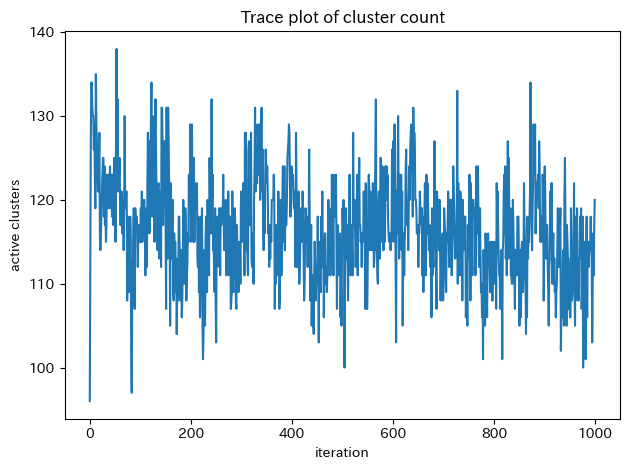

In [39]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import dirichlet, beta
from tqdm import tqdm

# ---------- 共通ユーティリティ ----------
def _gauss_kernel(x, phi, kappa):
    diff = x[:, None, :] - phi[None, :, :]
    return np.exp(-np.sum(diff**2, axis=-1) / (2.0 * kappa**2))

def _log_multinom(counts, probs, eps=1e-20):
    return np.sum(counts * np.log(probs + eps), axis=-1)

def _compute_pi(psi):
    psi = np.clip(psi, 1e-300, 1-1e-16)
    cum = np.cumprod(1-psi, axis=1)
    pi  = psi.copy()
    if pi.shape[1] > 1:
        pi[:,1:] *= cum[:,:-1]
    return pi
# -----------------------------------------

def train_ddp(
    X, Y, *, grid_coords=None,
    N=None,
    kappa=0.3, gamma=1.0, alpha0=1.0,
    J_max=30, n_iter=500, burnin=100, thin=1,
    sigma_phi=0.05, sigma_v=0.4,
    seed=0
):
    """
    Same signature, but fixes broadcasting error in Beta step and
    returns last‐iteration phi/v/theta in addition to full traces.
    """
    import numpy as np
    from numpy.random import default_rng
    from scipy.stats import dirichlet, beta
    rng = default_rng(seed)

    n, d = X.shape
    K    = Y.shape[1]
    if N is None:
        N = Y.sum(axis=1)

    # bounding box for φ
    if grid_coords is None:
        grid_coords = X
    mins, maxs = grid_coords.min(0), grid_coords.max(0)
    phi = grid_coords[rng.choice(len(grid_coords), J_max, replace=True)]

    v     = beta.rvs(1, gamma, size=J_max, random_state=rng)
    theta = dirichlet.rvs([alpha0/K]*K, size=J_max, random_state=rng)
    z     = rng.integers(J_max, size=n)
    u     = rng.uniform(0, .5, size=n)

    # storage
    n_store = max(0, (n_iter-burnin)//thin)
    phi_tr   = np.empty((n_store, J_max, d))
    v_tr     = np.empty((n_store, J_max))
    theta_tr = np.empty((n_store, J_max, K))
    trace_k  = []
    store_ix = 0

    for it in tqdm(range(n_iter)):
        Kmat = _gauss_kernel(X, phi, kappa)    # (n,J_max)
        psi  = v * Kmat
        pi   = _compute_pi(psi)

        # ----- z Gibbs
        lp = np.log(pi) + _log_multinom(Y[:,None,:], theta[None,:,:])
        pz = np.exp(lp - lp.max(1, keepdims=True))
        pz /= pz.sum(1, keepdims=True)
        z  = np.array([rng.choice(J_max, p=pz[i]) for i in range(n)])

        # ----- slice
        u = rng.uniform(0, pi[np.arange(n), z])
        L = int((np.cumsum(psi,1) < (1-u.min())).any(0).sum()) + 1
        L = min(max(L, 3), J_max)
        active = slice(0, L)

        # ----- θ Dirichlet
        for h in range(L):
            y_sum = Y[z==h].sum(0)
            theta[h] = rng.dirichlet(alpha0/K + y_sum if y_sum.any()
                                     else [alpha0/K]*K)

        # ----- v  共役 Beta  (use explicit counts of length L)
        m = np.array([(z==h).sum() for h in range(L)])
        bmask = (u[:,None] < psi[:,active])
        r = np.array([(bmask[:,h] & (z>h)).sum() for h in range(L)])
        v[active] = beta.rvs(1+m, gamma+r, random_state=rng)

        # ----- φ MH
        for h in range(L):
            prop = phi[h] + rng.normal(scale=sigma_phi, size=d)
            if ((prop < mins).any()) or ((prop > maxs).any()):
                continue
            psi_new = psi.copy()
            psi_new[:,h] = v[h] * _gauss_kernel(X, prop[None,:], kappa)[:,0]
            pi_new = _compute_pi(psi_new)
            idx = z >= h
            if np.log(rng.uniform()) < np.sum(
                np.log(pi_new[np.arange(n)[idx], z[idx]]+1e-20) -
                np.log(pi   [np.arange(n)[idx], z[idx]]+1e-20)
            ):
                phi[h] = prop; psi = psi_new; pi = pi_new

        # ----- v MH (logit)
        for h in range(L):
            logit = np.log(v[h]) - np.log(1-v[h])
            logit_p = logit + rng.normal(scale=sigma_v)
            v_p = 1/(1+np.exp(-logit_p))
            log_prior = beta.logpdf(v_p,1,gamma) - beta.logpdf(v[h],1,gamma)
            psi_new = psi.copy(); psi_new[:,h] = v_p * Kmat[:,h]
            pi_new  = _compute_pi(psi_new)
            idx = z >= h
            log_like = np.sum(
                np.log(pi_new[np.arange(n)[idx], z[idx]]+1e-20) -
                np.log(pi    [np.arange(n)[idx], z[idx]]+1e-20)
            )
            if np.log(rng.uniform()) < (log_prior + log_like):
                v[h] = v_p; psi = psi_new; pi = pi_new

        # trace
        trace_k.append(np.unique(z).size)
        if it>=burnin and (it-burnin)%thin==0:
            phi_tr[store_ix], v_tr[store_ix], theta_tr[store_ix] = phi, v, theta
            store_ix += 1

    return dict(phi_trace=phi_tr,
                v_trace=v_tr,
                theta_trace=theta_tr,
                phi=phi, v=v, theta=theta,   # last sample for prediction
                z=z,
                trace_clusters=np.array(trace_k))

kappa = 0.002

result = train_ddp(
        X=site_coords, 
        Y=counts_all, 
        grid_coords=grid_coords,
        kappa=kappa, 
        J_max=1000,
        n_iter=1000, 
        burnin=100, 
        thin=1, 
        seed=1
    )

# ---- trace plot ----
plt.figure()
plt.plot(result['trace_clusters'])
plt.xlabel('iteration')
plt.ylabel('active clusters')
plt.title('Trace plot of cluster count')
plt.tight_layout()
plt.show()

In [ ]:
def predict_pi_batch(x_new, result, kappa, aggregate="mean"):
    """
    Posterior predictive π(x_new) for a batch of points.
    ----------------------------------------------------
    Parameters
    ----------
    x_new : ndarray (m,2)
    result : dict  (output of train_ddp)
    kappa : float  kernel bandwidth used in training
    aggregate : {"mean","median","last","all"}
        * mean   : posterior mean (default)
        * median : element-wise posterior median
        * last   : π from the last saved sampleのみ
        * all    : 各サンプルごとの配列を返す  (S,m,K)

    Returns
    -------
    ndarray
        shape (m,K)  or (S,m,K)  depending on `aggregate`
    """
    phi_tr   = result["phi_trace"]      # (S,J,2)
    v_tr     = result["v_trace"]        # (S,J)
    theta_tr = result["theta_trace"]    # (S,J,K)

    S_reduced = 20
    # サンプルが多すぎるので、50個にランダムに減らす
    indices = np.random.choice(phi_tr.shape[0], S_reduced, replace=False)
    phi_tr = phi_tr[indices]
    v_tr   = v_tr[indices]
    theta_tr = theta_tr[indices]

    # --- ヘルパ: log-safe stick-breaking ----------------
    def _pi_from_psi(psi):
        log1m = np.log1p(-psi)                 # log(1-ψ)
        log_cum = np.cumsum(log1m, axis=1)
        log_cum = np.pad(log_cum, ((0,0),(1,0)),
                         constant_values=0)[:, :-1]
        log_pi = np.log(psi) + log_cum
        return np.exp(log_pi)

    # ---------- サンプルが無い場合は最後の値で ----------
    if phi_tr.size == 0 or aggregate == "last":
        phi = result["phi"]; v = result["v"]; theta = result["theta"]
        Kmat = _gauss_kernel(x_new, phi, kappa)
        psi  = v * Kmat
        pi   = _pi_from_psi(psi)
        pi /= pi.sum(1, keepdims=True)
        return pi @ theta

    # ---------- MCMC 循環 --------------------------------
    S, J, _ = phi_tr.shape
    m       = x_new.shape[0]
    K       = theta_tr.shape[2]
    out     = np.empty((S, m, K))

    for s in tqdm(range(S)):
        Kmat = _gauss_kernel(x_new, phi_tr[s], kappa)   # (m,J)
        psi  = v_tr[s] * Kmat
        pi   = _pi_from_psi(psi)
        pi  /= pi.sum(1, keepdims=True)
        out[s] = pi @ theta_tr[s]

    if aggregate == "all":
        return out
    if aggregate == "median":
        return np.median(out, axis=0)
    # default: mean
    return out.mean(axis=0)

pi_grid = predict_pi_batch(
    grid_coords, 
    result, 
    kappa=kappa, 
    aggregate="mean"
)


 15%|█▌        | 3/20 [04:05<23:18, 82.25s/it]

/tmp/ipykernel_3241456/2390322944.py:8: RuntimeWarning: invalid value encountered in divide
  ratio_true = counts_all / counts_all.sum(axis=1, keepdims=True)


target_period: 0, target_origin: 神津島


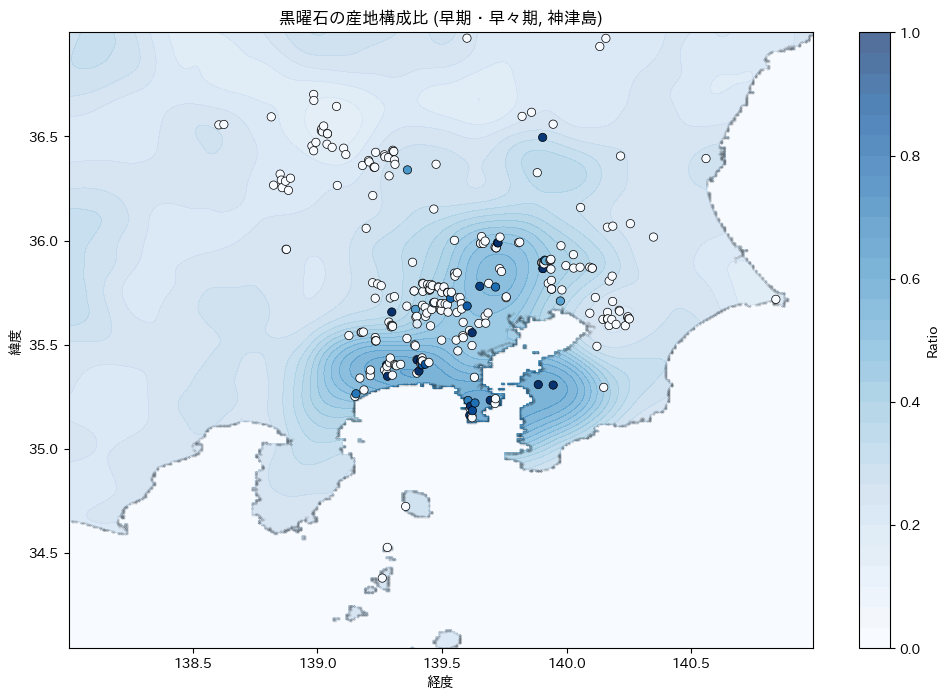

In [ ]:
plot_result(pi_grid, 0)

In [88]:
site_coords

array([[0.63801499, 2.41910732],
       [0.63805019, 2.41945701],
       [0.638688  , 2.42277639],
       [0.63296601, 2.42293785],
       [0.63389084, 2.42339581],
       [0.63339045, 2.42348023],
       [0.63276092, 2.42353953],
       [0.63329477, 2.42377183],
       [0.6275905 , 2.42381463],
       [0.62758888, 2.42383549],
       [0.63253046, 2.42397726],
       [0.63354568, 2.42412132],
       [0.63624985, 2.42562238],
       [0.63584839, 2.42574101],
       [0.64056458, 2.42574266],
       [0.64006067, 2.42575559],
       [0.63655062, 2.42589936],
       [0.63752704, 2.42628186],
       [0.63768211, 2.42631124],
       [0.63743281, 2.42636094],
       [0.6379196 , 2.42644222],
       [0.63639546, 2.42667642],
       [0.63727332, 2.42670591],
       [0.63727313, 2.4267124 ],
       [0.63612937, 2.42703778],
       [0.63956031, 2.42734548],
       [0.63294007, 2.42740183],
       [0.6360629 , 2.42784256],
       [0.63553368, 2.42799382],
       [0.62036989, 2.42821109],
       [0.